In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pylab import plt
plt.style.use('seaborn')

In [2]:
def obtener_datos(accion, fecha):
    url = 'http://bit.ly/oncedos-{}'.format(accion)
    
    df = pd.read_csv(url, index_col = 0, parse_dates = True)
    df.sort_index(inplace = True)
    df = df[df.index > fecha]
    
    return(df)
    

In [3]:
def calculos(df, ventana, num_sigmas):
    df['PM'] = df['Close'].rolling(ventana).mean()
    df['+2sigma'] = (df['Close'].rolling(ventana).std()*num_sigmas) + df['PM']
    df['-2sigma'] = (df['Close'].rolling(ventana).std()*(-num_sigmas)) + df['PM']
    df.dropna(inplace = True)
    
    return(df)

In [4]:
def estrategia(df):
    
    df['Posicion'] = np.nan
    df.loc[df['Close'] > df['+2sigma'], ['Posicion']] = -1
    df.loc[df['Close'] < df['-2sigma'], ['Posicion']] = 1
    df.fillna(method='ffill', inplace = True)
    
    return(df)

In [5]:
def back_testing(df):
    
    df['Retornos'] = np.log(df['Close']/df['Close'].shift(1))
    df['Estrategia'] = df['Posicion'].shift(1) * df['Retornos']
    
    df.dropna(inplace = True)
    
    df['Ret_Acum'] = np.exp(df['Retornos'].cumsum())
    df['Estr_Acum'] = np.exp(df['Estrategia'].cumsum())
    
    return(df)

In [6]:
def graficar(df):
    df.plot(figsize=(12,8))
    plt.show();

In [11]:
def crear_df_vacio(fecha_inicial):
    fecha_final = '10-4-2019'
    rango_fecha = pd.date_range(fecha_inicial, fecha_final)
    
    df = pd.DataFrame(index = rango_fecha)
    
    return(df)
    

In [17]:
def resultados(df, df2, pm, sigma):
    
    df2 = df2.join(df['Estr_Acum'])
    df2.rename(columns = {'Estr_Acum':'{}-{}'.format(pm, sigma)},
              inplace = True)
    
    df2.dropna(inplace = True)
    
    return(df2)

In [22]:
def resultados_lista(df, df2, pm, sigma):
    
    df2 = df2.join(df['Estr_Acum'])
    df2.rename(columns = {'Estr_Acum':'{}-{}'.format(pm, sigma)},
              inplace = True)
    
    return(df2)

In [7]:
accion = 'ipc'
fecha = '1-1-2016'
pm = 20
sigma = 2

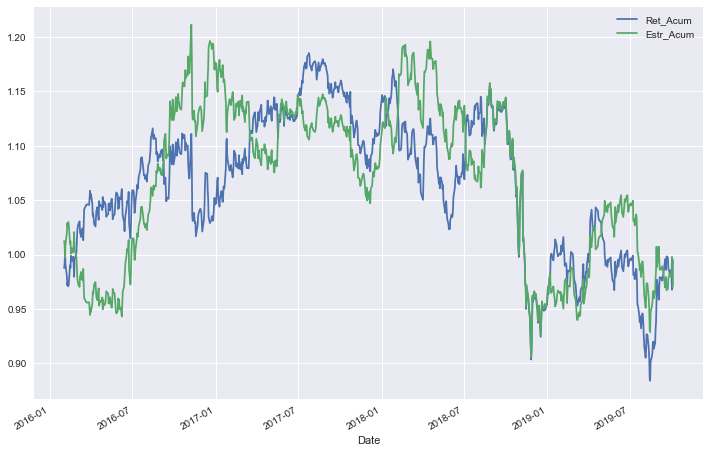

In [8]:
ipc = obtener_datos(accion, fecha)
ipc = calculos(ipc, pm, sigma)
ipc = estrategia(ipc)
ipc = back_testing(ipc)
graficar(ipc[['Ret_Acum','Estr_Acum']])

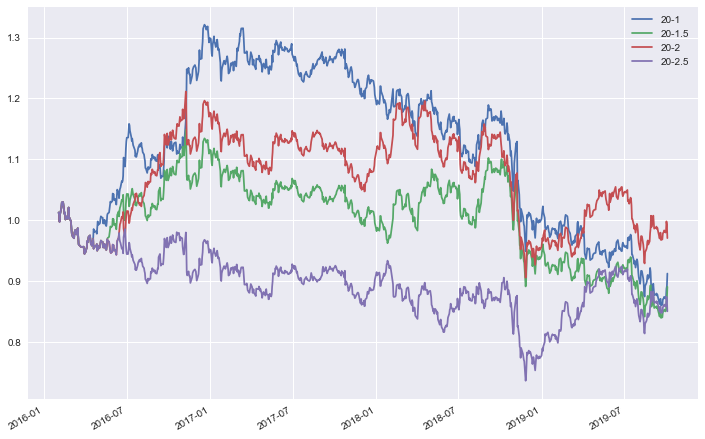

In [21]:
retornos = crear_df_vacio(fecha)

for sigma in [1, 1.5, 2, 2.5]:
    
    ipc = obtener_datos(accion, fecha)
    ipc = calculos(ipc, pm, sigma)
    ipc = estrategia(ipc)
    ipc = back_testing(ipc)
    retornos = resultados(ipc, retornos, pm, sigma)
    
graficar(retornos)

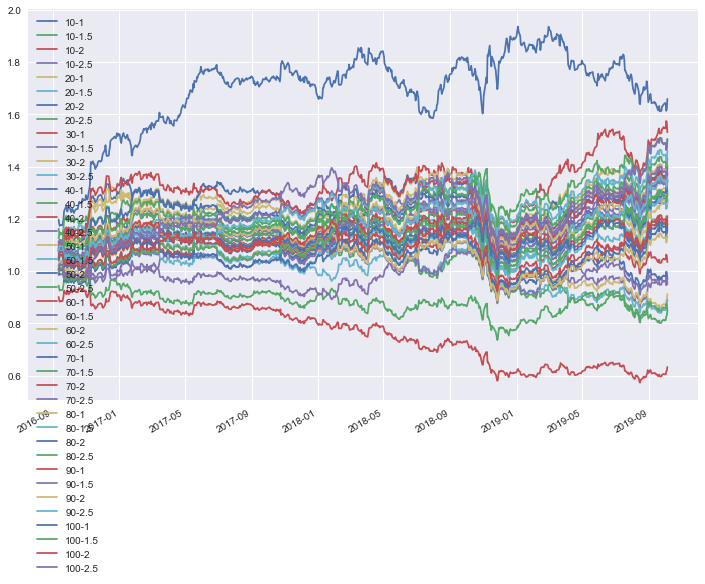

In [25]:
retornos = crear_df_vacio(fecha)

for pm in np.arange(10,101, 10):
    for sigma in [1, 1.5, 2, 2.5]:

        ipc = obtener_datos(accion, fecha)
        ipc = calculos(ipc, pm, sigma)
        ipc = estrategia(ipc)
        ipc = back_testing(ipc)
        retornos = resultados(ipc, retornos, pm, sigma)
    
graficar(retornos)

In [26]:
retorno_estrategia = retornos.iloc[-1,:]

In [30]:
retorno_estrategia.sort_values(ascending=False, inplace = True)

In [31]:
retorno_estrategia

10-1       1.658977
60-1       1.531314
100-1.5    1.505266
100-2.5    1.504280
80-1.5     1.459858
70-1.5     1.433216
40-2       1.403959
60-2       1.402864
90-1.5     1.396180
50-2       1.379333
70-2       1.373062
90-2.5     1.359666
70-2.5     1.350874
60-1.5     1.347849
50-1.5     1.339650
50-1       1.338347
50-2.5     1.306501
30-2       1.301116
80-2.5     1.299744
70-1       1.286824
60-2.5     1.274408
40-2.5     1.273845
40-1       1.261400
80-1       1.257416
100-2      1.210710
90-1       1.196024
100-1      1.183139
30-2.5     1.177049
40-1.5     1.167341
80-2       1.161714
90-2       1.140179
30-1       1.034279
10-2.5     0.972408
20-2       0.970478
30-1.5     0.950052
20-1       0.912206
20-1.5     0.890422
20-2.5     0.850202
10-1.5     0.849682
10-2       0.632947
Name: 2019-10-04 00:00:00, dtype: float64

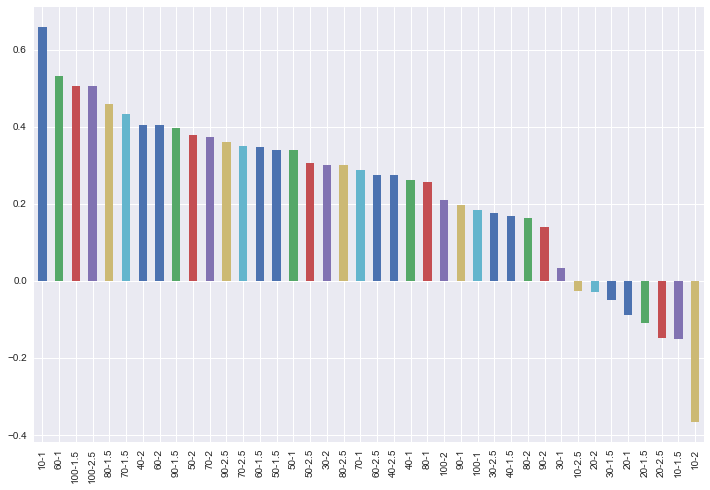

In [33]:
(retorno_estrategia-1).plot.bar(figsize = (12,8));